Name: Jui-Yang (Ray) Wang

student ID: 8552258069

In [3]:
#2022 AME508 assignment_3

import torch
import random
import numpy as np
import torch.nn as nn
from torch.nn import Tanh as tanh
import torch.nn.functional as f
from numpy.core.function_base import linspace
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

Feed-forward loop from HW1

In [4]:
#@title
# call in the function from assignment 1.

class neuralnetwork(nn.Module):                                                 # here we inherit Module as the basis of our ML code.
    def __init__(self, input_dim, width, output_dim, depth, activation="tanh"): # preset the activation function as tanh
        super().__init__()
        self.activation = activation                                            # need activation function in method part.
        
        self.mlp = nn.ModuleList()                                              # apply modulelist here, sequential can also be applied. 
        for i in range(depth):
            if i == 0:                                                          # first layer
                fc = nn.Linear(input_dim, width)                                
            elif i == depth - 1:                                                # last layer
                fc = nn.Linear(width, output_dim)                               
            else:                                                               # all hidden layers, the size should be width*width
                fc = nn.Linear(width, width)
          

            nn.init.normal_(fc.weight, mean=0.0, std=1.0)
            nn.init.normal_(fc.bias, mean=0.0, std=1.0)
            self.mlp.append(fc)                                                 #append all layers together


    def forward(self, X):                                                       #forward function, rolling the networks
        for i, fc in enumerate(self.mlp):
            # print(X.shape)
            X = fc(X)
            if i != len(self.mlp) - 1:
                if self.activation == "tanh":
                    X = torch.tanh(X)
                elif self.activation == "sin":
                    X = torch.sin(X)
                else:
                    raise ValueError("No activation function applied.")         #in case errors happening in the forward part
        return X

In [5]:
int_loss_array = [[[]for i in range(4)] for j in range(3)]
bc_loss_array = [[[]for i in range(4)] for j in range(3)]
total_loss_array = [[[]for i in range(4)] for j in range(3)]
solution_array = [[[]for i in range(4)] for j in range(3)]
# print(cases[1][1].item())


def dudx(u,x):
  return torch.autograd.grad(u,x,grad_outputs=torch.ones_like(x),
                                   create_graph=True,retain_graph=True)[0]
def ddudx(dudx,x):
  return torch.autograd.grad(dudx,x,grad_outputs=torch.ones_like(x),
                                   create_graph=True,retain_graph=True)[0]



Training

In [6]:
cases = torch.tensor([[0.1,0.1],[10,0.1],[0.1,50],[10,50]])

epochs = 20000
int_loss = 0
lambda_b = 10

for i in range(3):
  for q in range(4):
    model = neuralnetwork(input_dim=1, width=20, output_dim=1, depth=5, activation="tanh")
    params = model.parameters()
    optim = torch.optim.Adam(params, lr=0.0001, weight_decay=1e-7)
    for k in range(epochs):
      optim.zero_grad()
      x = torch.linspace(0,1,100,requires_grad=True).unsqueeze(1)
      random.shuffle(x.detach().numpy())
      u = model(x)
      u0 = model(torch.Tensor([0]))
      u1 = model(torch.Tensor([1]))

      first_der = dudx(model(x),x)
      second_der = ddudx(first_der,x)
      
      eqn = second_der - cases[q][0]*first_der + cases[q][1]*u*(1-u)
      int_loss =eqn.pow(2).mean()
      bc_loss = u0**2 + (u1-1)**2
      total_loss = int_loss + lambda_b * bc_loss
      total_loss.backward()
      step = optim.step()

      int_loss_array[i][q].append(int_loss.detach())
      bc_loss_array[i][q].append(bc_loss.detach())
      total_loss_array[i][q].append(total_loss.detach())
    solution_array[i][q].append(model)




In [7]:
print(torch.linspace(1,epochs,epochs).shape)
print(torch.tensor(int_loss_array[0][0]).shape)

torch.Size([20000])
torch.Size([20000])


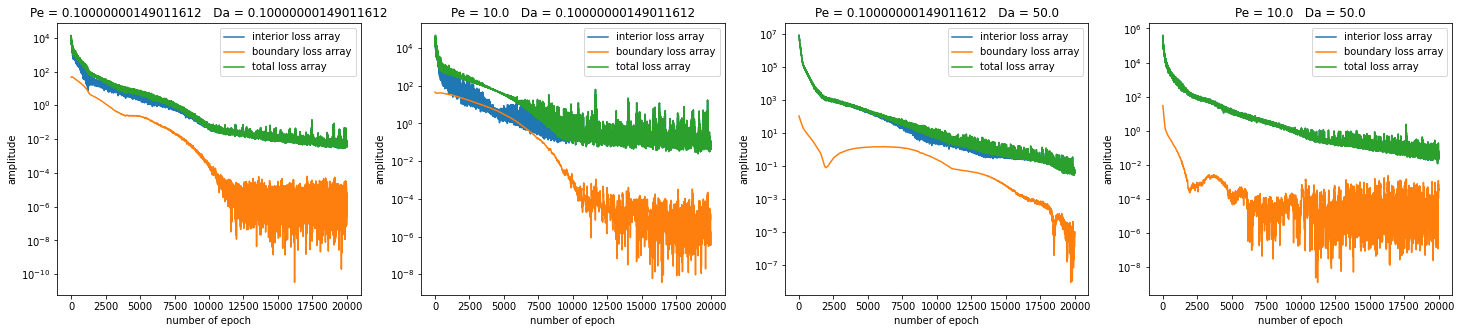

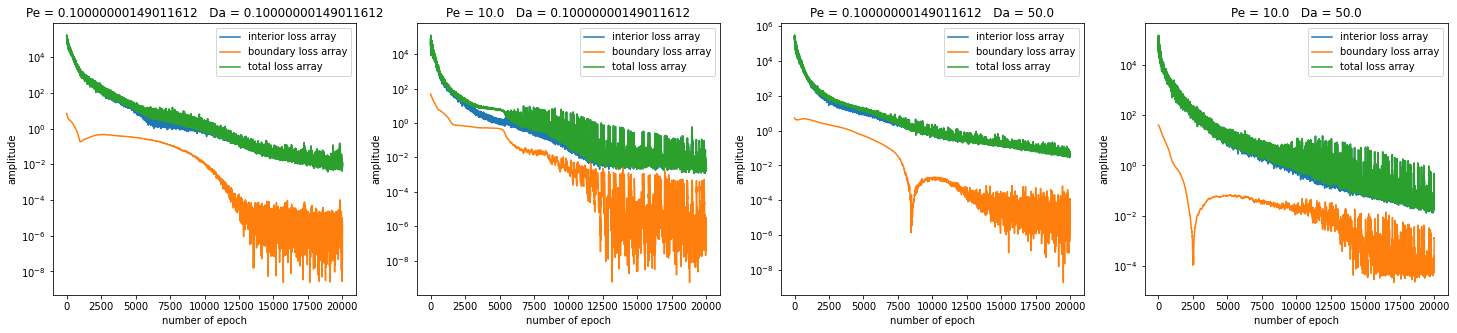

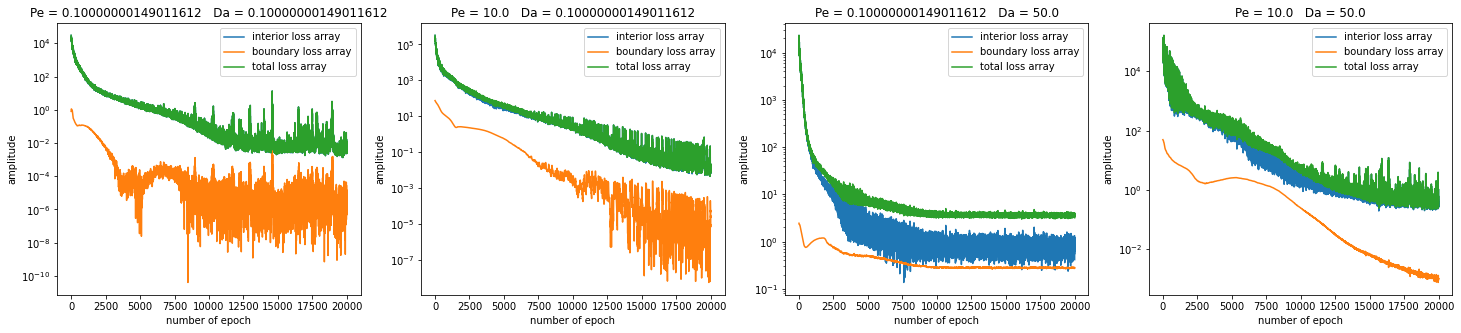

In [10]:
for i in range(3):
  fig, ax = plt.subplots(1, 4, figsize=(25, 5))
  for q in range(4):
    ax[q].set_title("Pe = {}".format(torch.round(cases[q][0], decimals=1)) + "   Da = {}".format(torch.round(cases[q][1], decimals=1)))
    ax[q].plot(torch.linspace(1,epochs,epochs), torch.tensor(int_loss_array[i][q]), label='interior loss array')
    ax[q].plot(torch.linspace(1,epochs,epochs), torch.tensor(bc_loss_array[i][q]), label='boundary loss array')
    ax[q].plot(torch.linspace(1,epochs,epochs), torch.tensor(total_loss_array[i][q]), label='total loss array')
    ax[q].set_yscale('log')
    ax[q].set_xlabel('number of epoch')
    ax[q].set_ylabel('amplitude')
    ax[q].legend()

plt.show()


In [11]:
for i in range(4):
  for j in range(3):
    print('Total loss in {} set of different parameters'.format(i+1), 'in trial {}'.format(j+1), 'is {}'.format(total_loss_array[j][i][-1].item()))


x_true = [[]for i in range(4)]
y_true = [[]for i in range(4)]

from google.colab import drive
drive.mount('/content/drive')
for line in open ('/content/drive/My Drive/USC related/AME508/2022/Pe_0.1_Da_0.1.txt', 'r'):
  lines = [i for i in line.split()]
  x_true[0].append(float(lines[0]))
  y_true[0].append(float(lines[1]))

for line in open ('/content/drive/My Drive/USC related/AME508/2022/Pe_10_Da_0.1.txt', 'r'):
  lines = [i for i in line.split()]
  x_true[1].append(float(lines[0]))
  y_true[1].append(float(lines[1]))

for line in open ('/content/drive/My Drive/USC related/AME508/2022/Pe_0.1_Da_50.txt', 'r'):
  lines = [i for i in line.split()]
  x_true[2].append(float(lines[0]))
  y_true[2].append(float(lines[1]))

for line in open ('/content/drive/My Drive/USC related/AME508/2022/Pe_10_Da_50.txt', 'r'):
  lines = [i for i in line.split()]
  x_true[3].append(float(lines[0]))
  y_true[3].append(float(lines[1]))

Total loss in 1 set of different parameters in trial 1 is 0.003583112731575966
Total loss in 1 set of different parameters in trial 2 is 0.007424174342304468
Total loss in 1 set of different parameters in trial 3 is 0.0048581138253211975
Total loss in 2 set of different parameters in trial 1 is 0.087625652551651
Total loss in 2 set of different parameters in trial 2 is 0.002467994811013341
Total loss in 2 set of different parameters in trial 3 is 0.009265328757464886
Total loss in 3 set of different parameters in trial 1 is 0.04413105547428131
Total loss in 3 set of different parameters in trial 2 is 0.04623718932271004
Total loss in 3 set of different parameters in trial 3 is 3.1907644271850586
Total loss in 4 set of different parameters in trial 1 is 0.02448447234928608
Total loss in 4 set of different parameters in trial 2 is 0.16598336398601532
Total loss in 4 set of different parameters in trial 3 is 0.5866479277610779
Drive already mounted at /content/drive; to attempt to forcibl

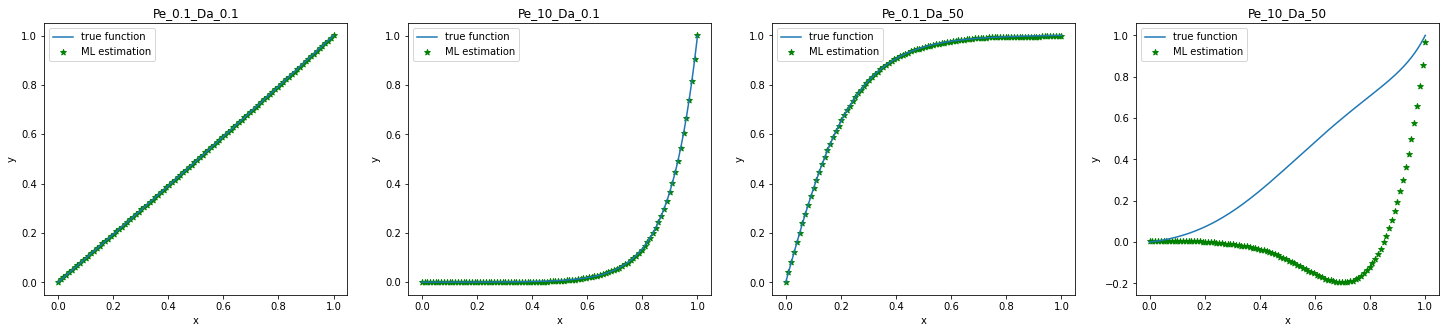

In [12]:
x_ml = torch.linspace(0,1,steps=100).unsqueeze(1)
u_ex = [[]for i in range(4)]
u_ex[0] = solution_array[1][0][0](x_ml).detach()
u_ex[1] = solution_array[0][1][0](x_ml).detach()
u_ex[2] = solution_array[0][2][0](x_ml).detach()
u_ex[3] = solution_array[1][3][0](x_ml).detach()


fig, ax = plt.subplots(1, 4, figsize=(25, 5))

for m in range(4):
  ax[m].plot(x_true[m], y_true[m], label = 'true function')
  ax[m].scatter(x_ml, u_ex[m], label='ML estimation',marker='*', c ='g')
  ax[m].set_xlabel('x')
  ax[m].set_ylabel('y')
  ax[m].legend()

ax[0].title.set_text("Pe_0.1_Da_0.1")
ax[1].title.set_text("Pe_10_Da_0.1")
ax[2].title.set_text("Pe_0.1_Da_50")
ax[3].title.set_text("Pe_10_Da_50")

With Lambda_b = 1000, Re-run Pe = 10, Da = 50

In [13]:
case = torch.tensor([10,50])

epochs = 20000
int_loss = 0
lambda_b = 1000

int_loss_array1 = [[]for i in range(3)]
bc_loss_array1 = [[]for i in range(3)]
total_loss_array1 = [[]for i in range(3)]
solution_array1 = [[]for i in range(3)]
for i in range(3):
  model = neuralnetwork(input_dim=1, width=20, output_dim=1, depth=5, activation="tanh")
  params = model.parameters()
  optim = torch.optim.Adam(params, lr=0.0001, weight_decay=1e-7)
  for k in range(epochs):
    optim.zero_grad()
    x = torch.linspace(0,1,100,requires_grad=True).unsqueeze(1)
    random.shuffle(x.detach().numpy())
    u = model(x)
    u0 = model(torch.Tensor([0]))
    u1 = model(torch.Tensor([1]))

    first_der = dudx(model(x),x)
    second_der = ddudx(first_der,x)
    
    eqn = second_der - case[0]*first_der + case[1]*u*(1-u)
    int_loss =eqn.pow(2).mean()
    bc_loss = u0**2 + (u1-1)**2
    total_loss = int_loss + lambda_b * bc_loss
    total_loss.backward()
    step = optim.step()

    int_loss_array1[i].append(int_loss.detach())
    bc_loss_array1[i].append(bc_loss.detach())
    total_loss_array1[i].append(total_loss.detach())
  solution_array1[i].append(model)




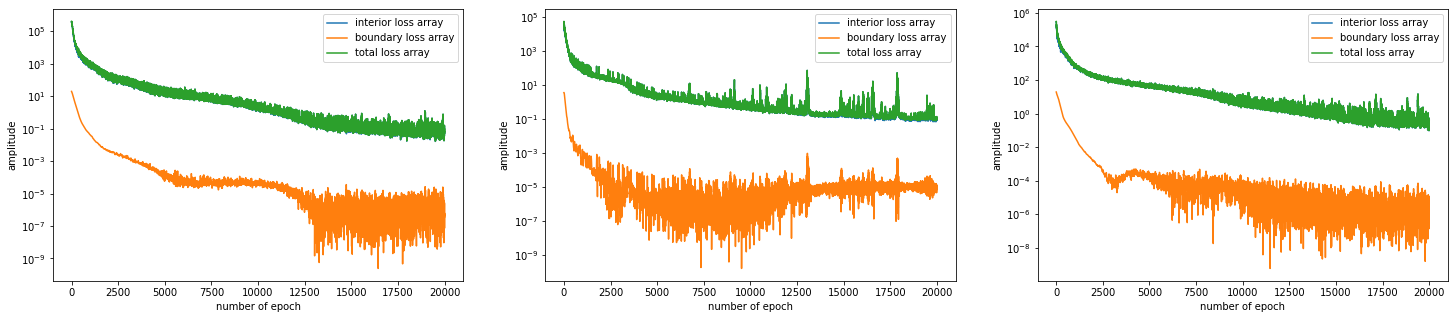

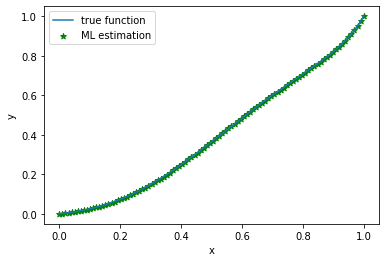

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
for q in range(3):
  ax[q].plot(torch.linspace(1,epochs,epochs), torch.tensor(int_loss_array1[q]), label='interior loss array')
  ax[q].plot(torch.linspace(1,epochs,epochs), torch.tensor(bc_loss_array1[q]), label='boundary loss array')
  ax[q].plot(torch.linspace(1,epochs,epochs), torch.tensor(total_loss_array1[q]), label='total loss array')
  ax[q].set_yscale('log')
  ax[q].set_xlabel('number of epoch')
  ax[q].set_ylabel('amplitude')
  ax[q].legend()

plt.show()

u_ex1 = []
u_ex1 = solution_array1[0][0](x_ml).detach()
plt.plot(x_true[3], y_true[3], label = 'true function')
plt.scatter(x_ml, u_ex1, label='ML estimation',marker='*', c ='g')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

Q5:

By increasing the value of lambda, the boundary condition is massively brought into machine's attention for speedy convergence. But it will still take a few trials to find out the best estimation. 


Q6:

To improve the accuracy of numerical solutions, one way is to increase the number of collocation points. We can also increase the size of our neural network for better model prediction.